### K Means algorithm without black boxes

K means is a clustering algorithm and the goal is to divide objects into groups.

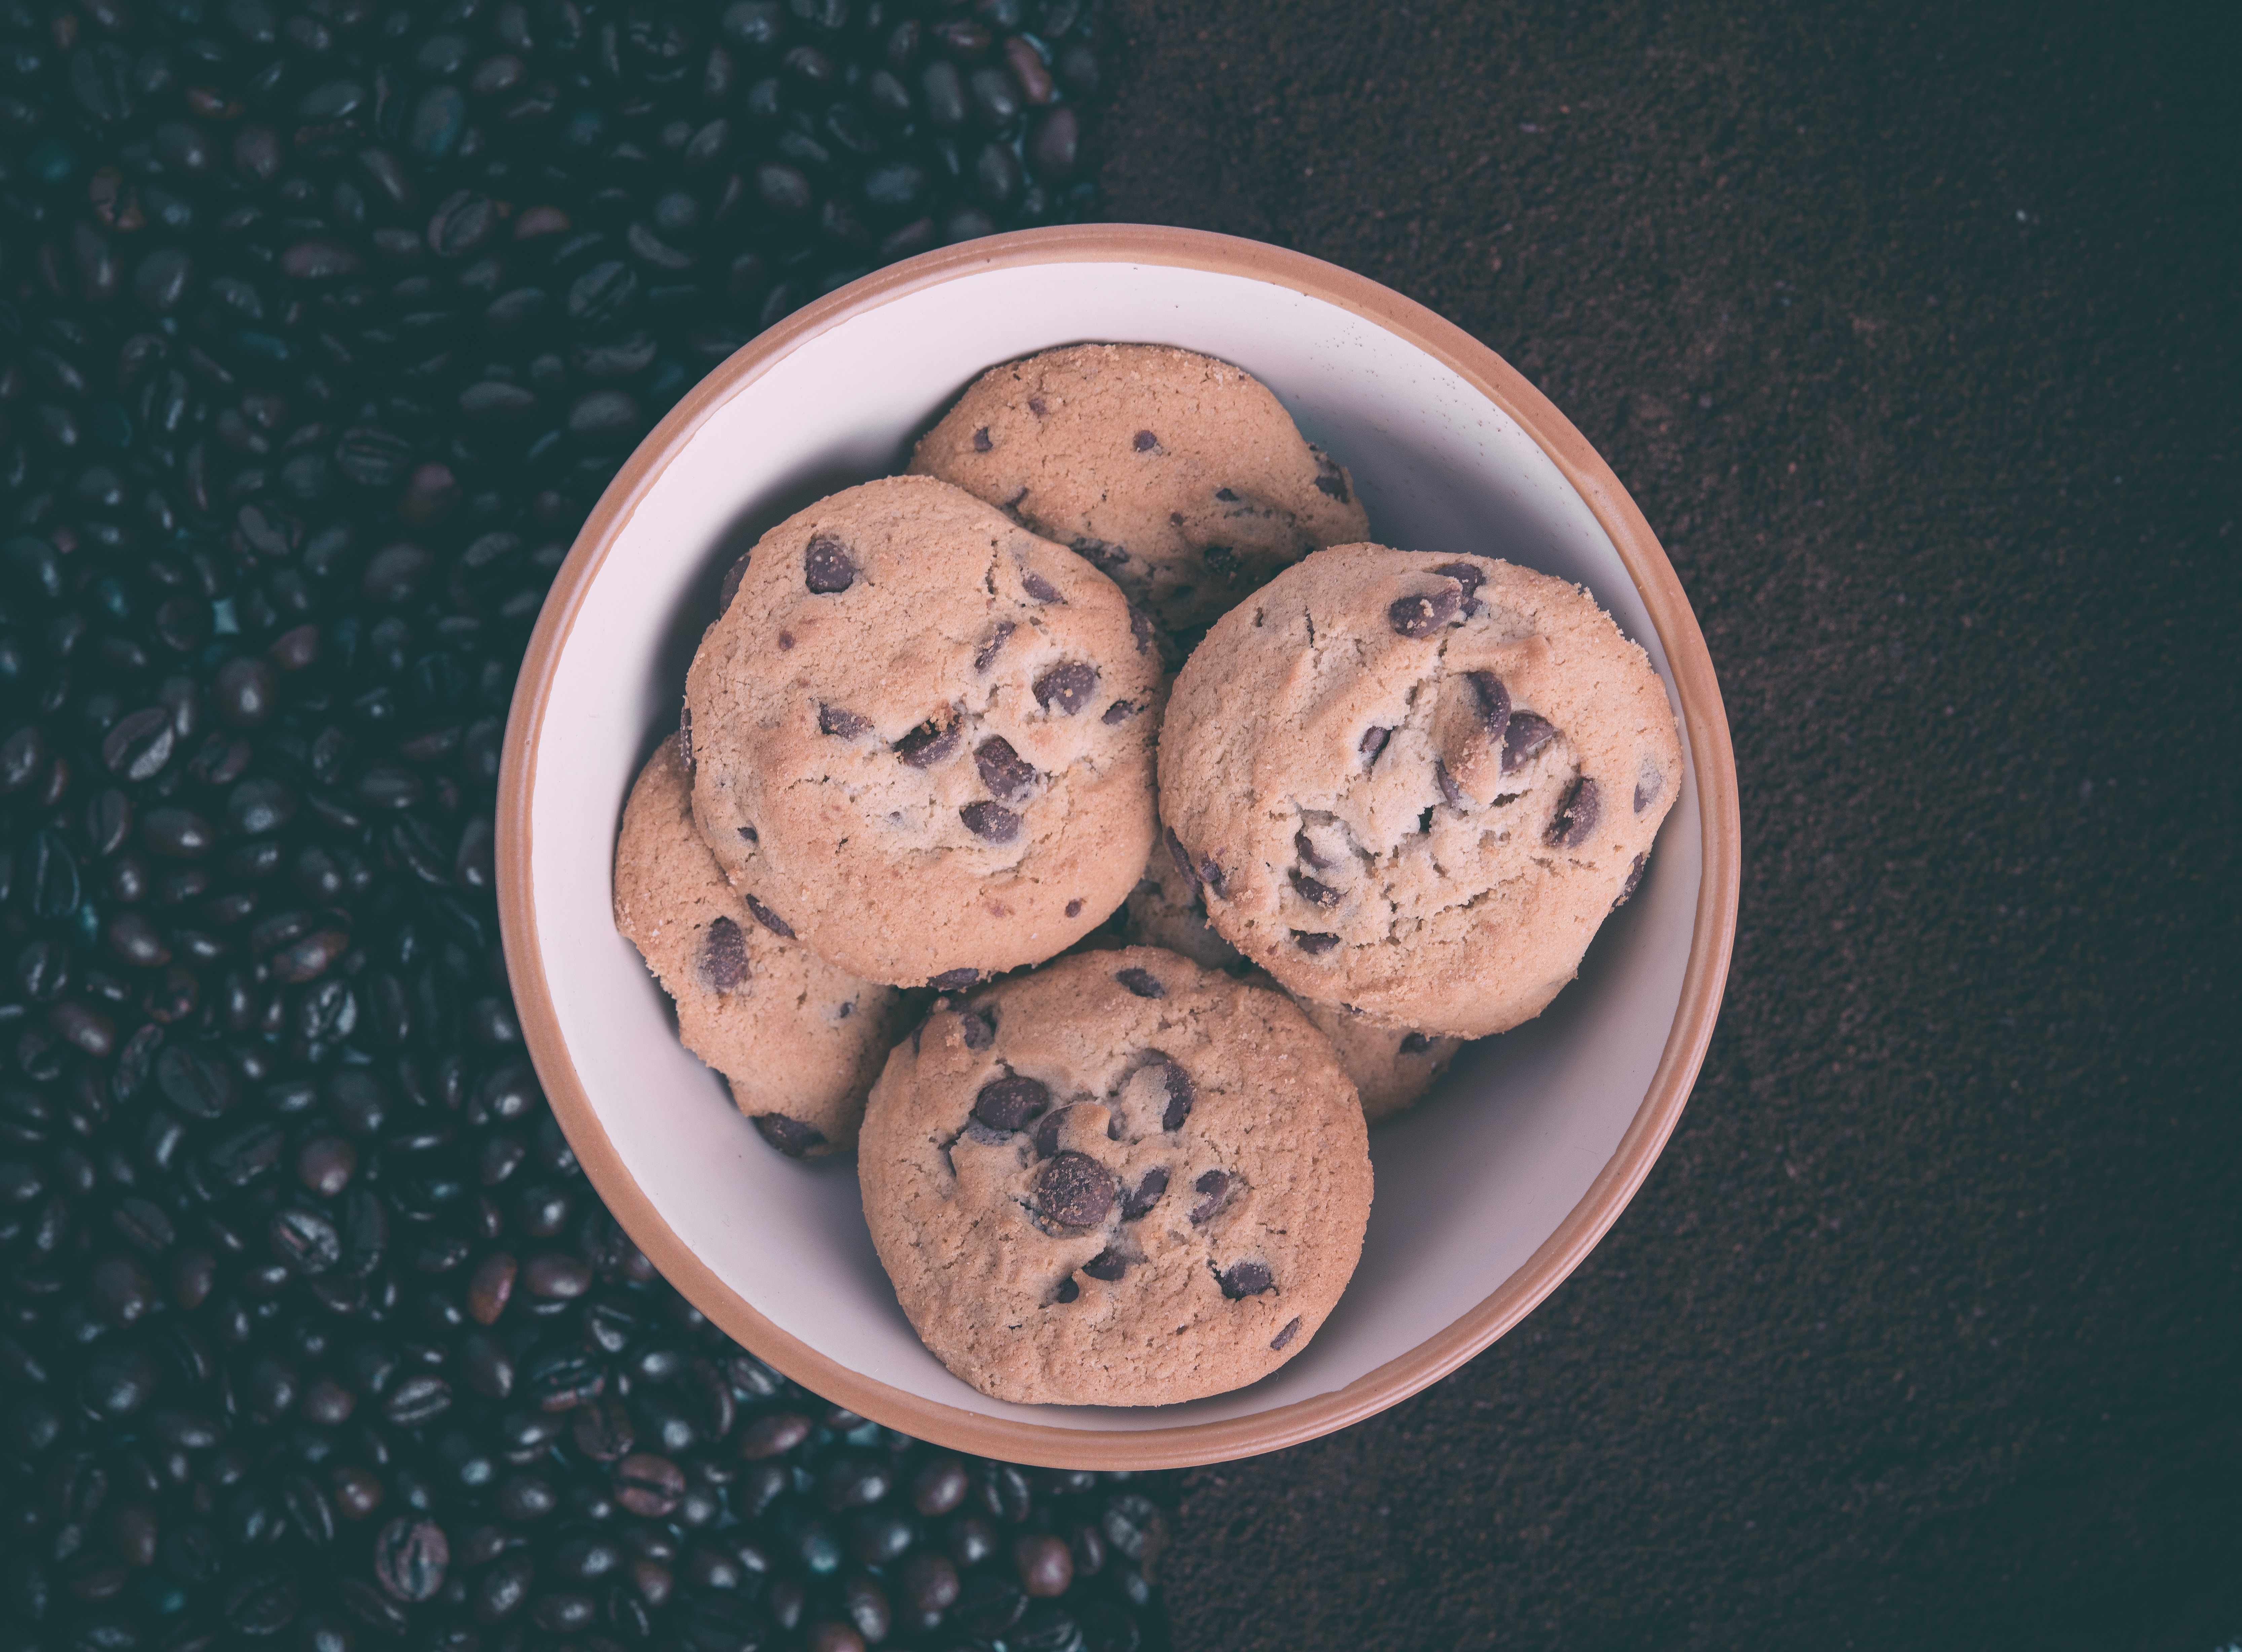
Photo by Alex on Unsplash

K means algorithm starts with a bunch of points that are not clustered. In the bigening you can have a notion of how many groups you will have and that depends a lot on the problem you are solving. Depending of the problem you may not know how many clusters is going to yield the best results.

Lets start with an example, lets sample from two normal distribution some points and that will represent our objects. The first normal distribution will have mean 0 and standart deviation 1 and the second will have mean 4 and standard deviation of 1. The reason for using two normal distribution is because it will form two clusters that we can easily identify.

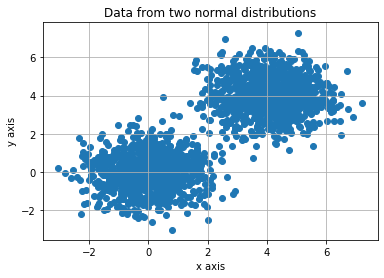

In [75]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

# First normal distribution
first_distribution = np.random.normal(0, 1, (1000, 2))
# Second normal distribution
second_distribution = np.random.normal(4, 1, (1000, 2))
# Stacking this two distribution together
data = np.vstack([first_distribution, second_distribution])

plt.scatter(data[:, 0], data[:, 1]);
plt.grid();
plt.title("Data from two normal distributions");
plt.xlabel("x axis");
plt.ylabel("y axis");

Now that we have our data, we need a way to cluster it.
K means algorithm uses another object that is not from our data, to represent the center of each cluster. The way that this center object is computed is represented by the following equation:

$$
    c_j = \frac{1}{|\{i:\pi(i) = j\}|} \sum_{i:\pi(i)=j}x_i
$$

c<sup>i</sup> represents each cluster center, in our example we are considering k equals two cluster, so j is {0, 1}.  
x<sup>i</sup> represents each object in our data.  
$\pi$(i) is:

$$
\pi(i) = argmin_{j=1,...,k}||x^i - c^j||^2
$$

Here, this formula is computing the squared distance between all the samples and all the cluster centers, and selecting the argmin for each cluster. That means, each cluster center will have a squared distance to each point in the data. $\pi$(i) returns the argmin for each cluster because we are selecting only the closest element to each cluster center.

So given this intuition of how the algorithm works, what is the goal(objective function) of the algorithm? The goal is to minimize the sum of the squared distances between samples and their cluster center, that is when we will have the center points that better represent each cluster of data points. That is the same as the following equation:

$$
min_{c,\pi}\frac{1}{m}\sum_{i=1}^m||x^i - c^{\pi(i)}||^2
$$

With the equation above, we defined our optimization problem. That is a NP-hard problem because we have to evaluate all m samples over all k clusters, that is O(m<sup>k</sup>).

To solve this issue, k means algorithm is an approximation of the optimal result, that is, we are solving it and finding a local minimum instead of the global minimum. There is a global solution, but it requires you to iterate over all possible clusterings and the number of iterations is exponential in the size of your data.

In the end the algorithm will be the following:

- Initialize k cluster centers, {c<sup>1</sup>, c<sup>2</sup>, ..., c<sup>k</sup>}, randomly
- Do  
    - Decide the cluster memberships of each data point, x<sup>i</sup>, by assigning it to the nearest cluster center.
$$
\pi(i) = argmin_{j=1,...,k}||x^i - c^j||^2
$$
    - Adjust the cluster centers
$$
    c_j = \frac{1}{|\{i:\pi(i) = j\}|} \sum_{i:\pi(i)=j}x_i
$$
- While any cluster center has been changed

So let's code this algorithm for the data that we have. Initializing two clusters randomly.

In [116]:
# Initialize centers with size [number of clusters, number of variables]
# The range allows is the range of the data for each dimension
c = np.zeros([2,2])
c[:,0] = np.random.uniform(np.min(data[:,0]), np.max(data[:,0]), 2)
c[:,1] = np.random.uniform(np.min(data[:,1]), np.max(data[:,1]), 2)

In [117]:
c

array([[-0.11408847, -1.90283187],
       [ 6.8241934 ,  5.36862544]])

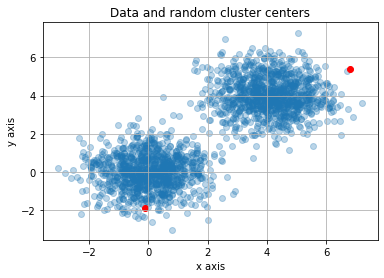

In [122]:
plt.scatter(data[:, 0], data[:, 1], alpha=0.3);
plt.scatter(c[:, 0], c[:, 1], color="red");
plt.grid();
plt.title("Data and random cluster centers");
plt.xlabel("x axis");
plt.ylabel("y axis");

Computing the distance from each cluster to each data point.

In [127]:
# The distance matrix will have the shape [number of samples, number of clusters]
dist = np.zeros((len(data[:, 0]), len(c[:, 0])))

for i in range(0, len(c[:,0])):
    dist[:, i] = ((data[:, 0] - c[i, 0]) ** 2 + (data[:, 1] - c[i, 1]) ** 2) ** (1/2)

Computing $\pi$

In [137]:
# assign each point to its respective cluster based on the smallest distance to it.
# {1: [[x1, y1], [x2, y2], ...]}
clusters = {}
pixels_classification = np.zeros(len(data[:, 0]))
for i in range(len(c[:, 0])):
    clusters[i] = []

for i in range(len(data[:, 0])):
    clusters[np.argmin(dist[i, :])].append([data[i, 0], data[i, 1]])
    pixels_classification[i] = np.argmin(dist[i, :])

Computing the new cluster centers

In [147]:
# Computing the mean for each cluster
new_c = np.zeros([2, 2])
for key in clusters.keys():
    new_c[key, :] = np.mean(clusters[key], 0)

In [148]:
new_c

array([[0.05804337, 0.04209646],
       [4.12793783, 4.049328  ]])

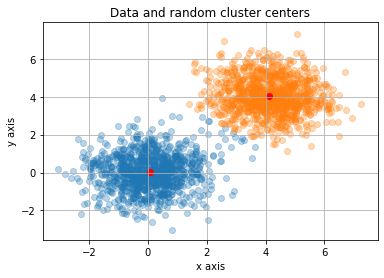

In [155]:
plt.scatter(data[np.where(pixels_classification==0)][:, 0], data[np.where(pixels_classification==0)][:, 1], alpha=0.3);
plt.scatter(data[np.where(pixels_classification==1)][:, 0], data[np.where(pixels_classification==1)][:, 1], alpha=0.3);
plt.scatter(new_c[:, 0], new_c[:, 1], color="red");
plt.grid();
plt.title("Data and random cluster centers");
plt.xlabel("x axis");
plt.ylabel("y axis");

The steps above must be wrapped in a loop, the stop criterion can be the moment when new cluster centers is equal to old cluster centers.

Things to pay attention:
- since we are randomly initializating the cluster centers, some really bady initializations can happen and your algorithm may not find the same solution every time. 
- The cost function (sum of squared distances for each cluster) always decrease and does not oscilate, the reason for that is because we are always find a better cluster.
- You can change the distance function, instead of squared distance you can use manhattan distance for example, k mean can be generalized to other distance metrics.

Entire code with more examples can be found in my github repository.

Thanks

### Another example using image this time
Applying k mean to cluster colors in an image.

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import time

image = plt.imread('image.png')
image = image * 255
image = image.astype('int32') 
rows = image.shape[0]
cols = image.shape[1]
pixels = np.zeros((rows*cols,3))

for i in range(rows):
    for j in range(cols):
        pixels[j*rows+i,0] = image[i,j,0]
        pixels[j*rows+i,1] = image[i,j,1]
        pixels[j*rows+i,2] = image[i,j,2]

In [158]:
# Kmeans
def my_kmeans(pixels, k):
    data_x = pixels[:, 0]
    data_y = pixels[:, 1]
    data_z = pixels[:, 2]

    timer_step_1 = 0
    timer_step_2_3 = 0
    timer_step_4_5 = 0
    
    number_of_centers = k
    
    start = time.time()
    # Code to avoid selecting repeated initial clusters
    #First it creates a dict storing all different values as keys
    non_repeat = {}
    for pixel in pixels:
        if (pixel[0], pixel[1], pixel[2]) in non_repeat:
            non_repeat[(pixel[0], pixel[1], pixel[2])] += 1
        else:
            non_repeat[(pixel[0], pixel[1], pixel[2])] = 1

    if (k > len(non_repeat.keys())):
        print("k is too large, reducing it to the max number of cluster possible: ", len(non_repeat.keys()))
        number_of_centers = len(non_repeat.keys())
    
    #Second we randomly select k number of points from the dict to be the centers
    #initial_center_indexes = []
    #index = int(random.uniform(0, len(non_repeat.keys())))
    #for i in range(0, k):
    #    while(index in initial_center_indexes):
    #        index = int(random.uniform(0, len(non_repeat.keys())))
    #    initial_center_indexes.append(index)    
    
    #Random initialize the centers, we will have 3 centers for now
    centers = []
    centers_x = []
    centers_y = []
    centers_z = []
    for i in range(0, number_of_centers):
        center_x = int(random.uniform(0, 255))
        center_y = int(random.uniform(0, 255))
        center_z = int(random.uniform(0, 255))
        center = (center_x, center_y, center_z)

        while(center in centers):
            center_x = int(random.uniform(0, 255))
            center_y = int(random.uniform(0, 255))
            center_z = int(random.uniform(0, 255))
            center = (center_x, center_y, center_z)

        centers.append(center)
        centers_x.append(center[0])
        centers_y.append(center[1])
        centers_z.append(center[2])
    end = time.time()
    timer_step_1 = end - start
    
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    data_z = np.array(data_z)
    centers_x = np.array(centers_x)
    centers_y = np.array(centers_y)
    centers_z = np.array(centers_z)
    pixels_classification = np.zeros(pixels.shape[0])

    # Compute distance from center using euclidean distance
    center_difference = 1.0
    empty_clusters = 0
    while (center_difference != 0.0):
        
        start = time.time()
        dist = np.zeros((len(data_x), len(centers_x)))
        for i in range(0, len(centers_x)):
            dist[:, i] = ((data_x - centers_x[i]) ** 2 + (data_y - centers_y[i]) ** 2 + (data_z - centers_z[i]) ** 2) ** (1/2)
        
        # assign each point to its respective cluster based on the smallest distance to it.
        # {1: [[x, y, z]]}
        clusters = {}
        for i in range(len(centers_x)):
            clusters[i] = []

        for i in range(len(data_x)):
            clusters[np.argmin(dist[i, :])].append([data_x[i], data_y[i], data_z[i]])
            pixels_classification[i] = np.argmin(dist[i, :])
        end = time.time()
        timer_step_2_3 += end - start
        
        start = time.time()
        # Compute new center, the new center is the average of the points in each cluster
        new_c_x = []
        new_c_y = []
        new_c_z = []
        for key in clusters.keys():
            data = clusters[key]
            if (len(data) != 0):
                mean_data = np.mean(data, 0).astype(np.int)
                new_c_x.append(mean_data[0])
                new_c_y.append(mean_data[1])
                new_c_z.append(mean_data[2])
            else:
                new_c_x.append(centers_x[key])
                new_c_y.append(centers_y[key])
                new_c_z.append(centers_z[key])
                empty_clusters += 1
        end = time.time()
        timer_step_4_5 += end - start

        # Compute objective function, the goal is to obtain the smallest possible objetive function,
        # that is the sum of the squared difference between sample and its center
        obj_func = 0
        for key in clusters.keys():
            data = clusters[key]
            if (len(data) != 0):
                obj_func = obj_func + (np.sum(np.sum(((np.array(data) - [new_c_x[key], new_c_y[key], new_c_z[key]]) ** 2), 0)))
        #print("Object function: ", obj_func)

        new_c_x = np.array(new_c_x)
        new_c_y = np.array(new_c_y)
        new_c_z = np.array(new_c_z)

        center_difference_x = centers_x - new_c_x
        center_difference_y = centers_y - new_c_y
        center_difference_z = centers_z - new_c_z

        #print(center_difference_x)
        #print(center_difference_y)
        #print(center_difference_z)

        centers_x = new_c_x
        centers_y = new_c_y
        centers_z = new_c_z

        center_difference = np.sum(center_difference_x ** 2)

    output = []
    for i in range(0, len(centers_x)):
        output.append([centers_x[i], centers_y[i], centers_z[i]])
    
    if empty_clusters:
        print("Warning, number of empty clusters: ", empty_clusters)
    
    #print("time step 1: ", timer_step_1)
    #print("time step 2 and 3: ", timer_step_2_3)
    #print("time step 4 and 5: ", timer_step_4_5)
    
    return pixels_classification.astype(np.int), np.array(output)

In [159]:
class1, centroid1 = my_kmeans(pixels, 3)

(-0.5, 999.5, 735.5, -0.5)

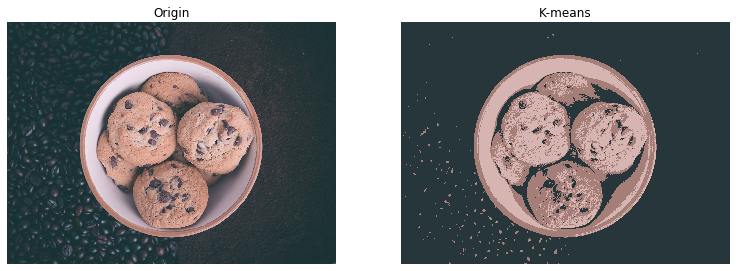

In [160]:
converted_image1 = np.zeros((rows, cols, 3))

for i in range(rows):
    for j in range(cols):
        converted_image1[i,j,:] = centroid1[class1[j*rows+i],:]
        
converted_image1 /= 255

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('Origin')
plt.imshow(image)
plt.axis('off')

plt.subplot(1,3,2)
plt.title('K-means')
plt.imshow(converted_image1)
plt.axis('off')